# RPORP

resolve the problem that gradients may vary widely in magnitudes. 

combines the idea of only using the sign of the gradient with the idea of adapting the step size individually for each weight




steps:
1/ look at the signs of the last two gradients for the weight.

2/ If they have the same sign, increase the step size multiplicatively(e.g by a factor of 1.2). If they’re different, that means we did too large of a step and jumped over a local minima, thus we should decrease the step size multiplicatively(e.g. by a factor of 0.5).

3/ Then, limit the step size between some two values. These values really depend on your application and dataset, good values that can be for default are 50 and a millionth, which is a good start.

4/ Now we can apply the weight update.

# Rmsprop

rprop doesnt work on large ds. The reason it doesn’t work is that it violates the central idea behind stochastic gradient descent, which is when we have small enough learning rate, it averages the gradients over successive mini-batches.

rmsprop keep the moving average of the squared gradients for each weight. And then we divide the gradient by square root the mean square.

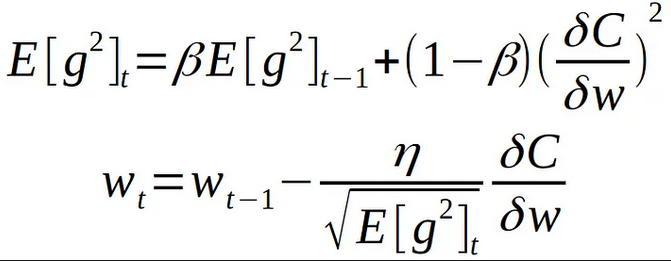

credits: Understanding RMSprop — faster neural network learning by Vitaly Bushaev

https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a

# DATA 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

2023-02-23 19:36:51.834247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 19:36:52.586333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ines/anaconda3/envs/tf/lib/
2023-02-23 19:36:52.586429: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ines/anaconda3/envs/tf/lib/
2023-02-23 19:36:52.586439: W tensorflow/compiler/tf2tensorr

## prep

In [2]:
train = pd.read_csv("train (1).csv")
test = pd.read_csv("test (1).csv")

In [3]:
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 



Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [5]:
Y_train

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

<AxesSubplot: xlabel='label', ylabel='count'>

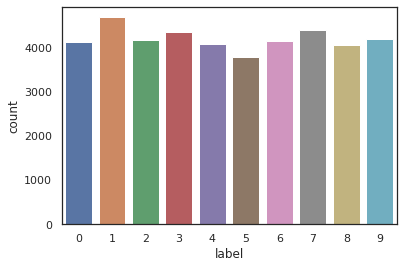

In [6]:
sns.countplot(x = Y_train, data = train)

In [7]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object



We perform a grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converg faster on [0..1] data than on [0..255].


In [9]:
X_train = X_train / 255.0
test = test / 255.0

In [10]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)



Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.


In [11]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=45)

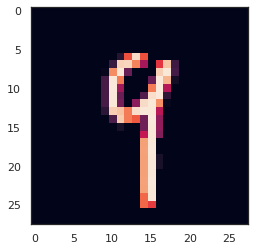

In [17]:
g = plt.imshow(X_train[6][:,:,0])

## CNN

In [18]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

2023-02-23 19:47:14.798493: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-23 19:47:14.798586: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-02-23 19:47:14.799357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. We could also have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

In [19]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


/home/ines/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [21]:
#LR the higher the bigger the step and quicker convergence
#reduceLRonPlateau: reduce LR by the factor

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [34]:
epochs = 4 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

## data augmentation

In [35]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [37]:
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/4
281/281 - 40s - loss: 0.0696 - accuracy: 0.9797 - val_loss: 0.0377 - val_accuracy: 0.9893 - lr: 0.0010 - 40s/epoch - 142ms/step
Epoch 2/4
281/281 - 41s - loss: 0.0687 - accuracy: 0.9799 - val_loss: 0.0274 - val_accuracy: 0.9919 - lr: 0.0010 - 41s/epoch - 145ms/step
Epoch 3/4
281/281 - 44s - loss: 0.0621 - accuracy: 0.9817 - val_loss: 0.0234 - val_accuracy: 0.9917 - lr: 0.0010 - 44s/epoch - 158ms/step
Epoch 4/4
281/281 - 46s - loss: 0.0618 - accuracy: 0.9817 - val_loss: 0.0276 - val_accuracy: 0.9927 - lr: 0.0010 - 46s/epoch - 164ms/step


## Eval

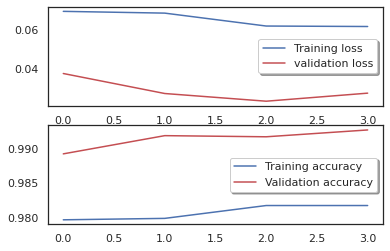

In [41]:
#curve train and val 

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


189/189 [==============================] - 1s 6ms/step


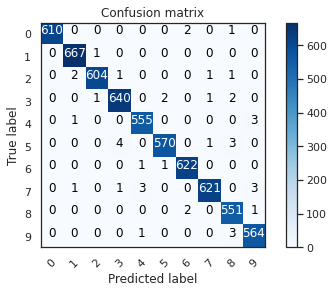

In [42]:
#confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

highest value = 4 where model predicted 3 instead of 5

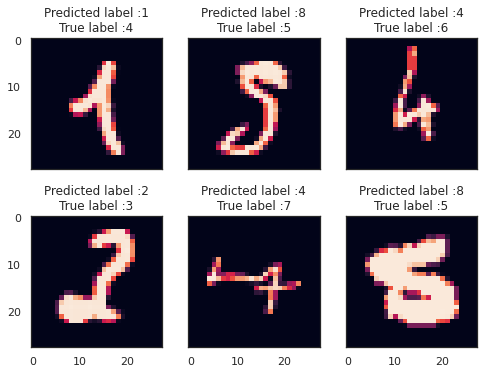

In [43]:
#errors

errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(8,6))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [47]:
# predict results
results = model.predict(test)


875/875 [==============================] - 5s 6ms/step


In [48]:
print(results)

[[2.4227714e-12 6.9098449e-11 9.9999994e-01 ... 5.5419780e-10
  1.1630966e-09 2.2099844e-12]
 [9.9995822e-01 2.1723421e-09 3.9696250e-08 ... 1.1217597e-08
  1.6686015e-06 4.7293156e-06]
 [5.5046934e-13 6.8894135e-12 6.6199428e-11 ... 1.1960247e-09
  6.2328461e-08 9.9999934e-01]
 ...
 [3.3278598e-19 9.7855380e-17 2.5834872e-12 ... 2.9666041e-14
  1.7417066e-10 2.6146221e-13]
 [2.4022384e-09 6.7216619e-09 2.7232765e-09 ... 1.6836407e-06
  1.4700100e-07 9.9997884e-01]
 [7.1743542e-14 2.5230569e-13 9.9999994e-01 ... 2.1668756e-12
  2.3948274e-09 3.7707408e-13]]


In [49]:
# select the index with the maximum probability
max_results = np.argmax(results,axis = 1)

In [50]:
max_results

array([2, 0, 9, ..., 3, 9, 2])